In [2]:
import numpy as np
import ast
import scipy   
import matplotlib.pyplot as plt
import cv2     
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image    
from keras.models import Model   
import sys

Using TensorFlow backend.


## Image pre-processing

In [3]:
def pretrained_path_to_tensor(img_path):

    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))

    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)

    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)

    # convert RGB -> BGR, subtract mean ImageNet pixel, and return 4D tensor
    return preprocess_input(x)

## Import ResNet, collect weights mapping GAP layer to prediction output layer

![Final section of ResNet-50 network](ResNet.PNG)

![](ResNet_summary.PNG)

In [4]:
def get_ResNet():

    # define ResNet50 model
    model = ResNet50(weights='imagenet')

    # get AMP layer weights (Average Max Pooling layer)
    all_amp_layer_weights = model.layers[-1].get_weights()[0]

    # extract wanted output
    ResNet_model = Model(inputs=model.input, 
        outputs=(model.layers[-4].output, model.layers[-1].output))    # collect as ouput the pred vector and activation output

    return ResNet_model, all_amp_layer_weights

## Get predicted Class and Class Activation Mapping

Class Activation Mapping = weighted sum of each feature channel (7x7) from last activation layer (7x7x2048) determining predicted class.
Each feature channel is upsampled to 224x224x1. The weighted sum highlights the areas of the picture contributing the most to the prediction.

![](ClassActivationMapping.PNG)

In [5]:
def ResNet_CAM(img_path, model, all_amp_layer_weights):

    # get filtered images from convolutional output + model prediction vector
    last_conv_output, pred_vec = model.predict(pretrained_path_to_tensor(img_path))  # activation output, pred vector

    # change dimensions of last convolutional output to 7 x 7 x 2048   (from 1x7x7x2048)
    last_conv_output = np.squeeze(last_conv_output) 

    # get model's prediction (number between 0 and 999, inclusive)
    pred = np.argmax(pred_vec)

    # bilinear upsampling to resize each filtered image to size of original image  ( 7 x 32 = 224 target dim)
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # dim: 224 x 224 x 2048

    # get AMP layer weights
    amp_layer_weights = all_amp_layer_weights[:, pred] # dim: (2048,)  - get weights from AMP nodes corresponding to prediction

    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult.reshape((224*224, 2048)), amp_layer_weights).reshape(224,224) # dim: 224 x 224

    # return class activation map
    return final_output, pred

## Assemble the parts to display heatmap

In [6]:
def plot_ResNet_CAM(img_path, ax1, ax2, model, all_amp_layer_weights):

    # load image, convert BGR --> RGB, resize image to 224 x 224,
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224))
    
    ax1.imshow(im, alpha=1)   # alpha is opacity parameter

    # plot image
    ax2.imshow(im, alpha=0.5)

    # get class activation map
    CAM, pred = ResNet_CAM(img_path, model, all_amp_layer_weights)

    # plot class activation map
    ax2.imshow(CAM, cmap='jet', alpha=0.5)             # overlay heat map from class activation mapping

    # load the dictionary that identifies each ImageNet category to an index in the prediction vector
    with open('imagenet1000_clsid_to_human.txt') as imagenet_classes_file:
        imagenet_classes_dict = ast.literal_eval(imagenet_classes_file.read())

    # obtain the predicted ImageNet category
    ax2.set_title(imagenet_classes_dict[pred]) 

## Run the model and display results

102858752/102853048 [==============================] - 1s 0us/step


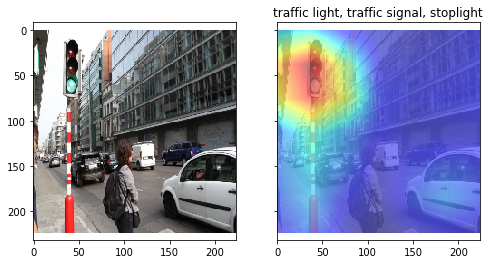

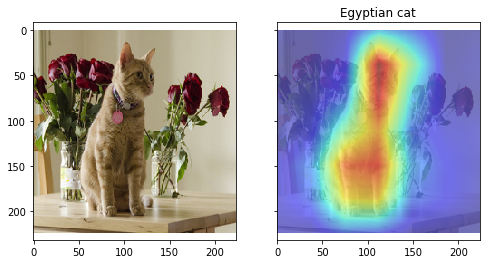

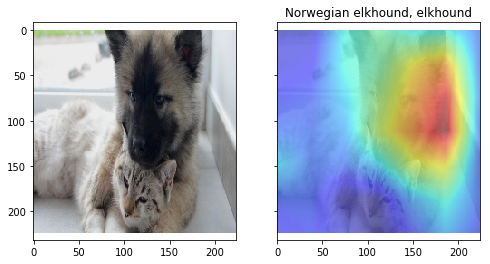

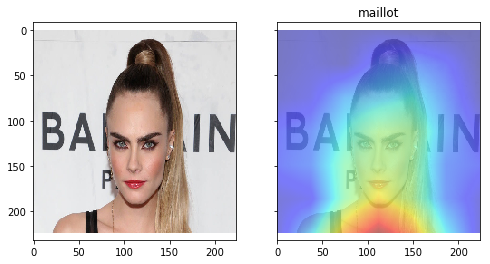

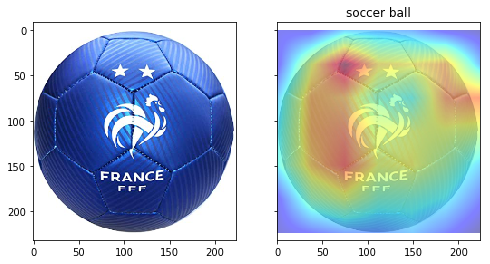

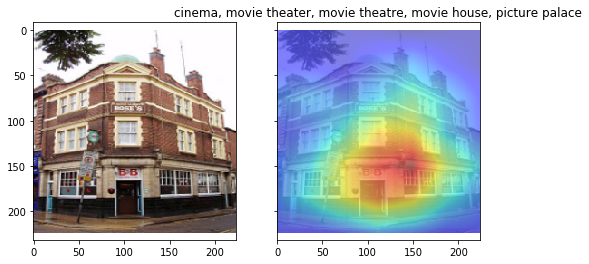

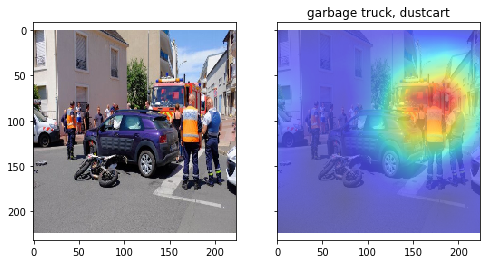

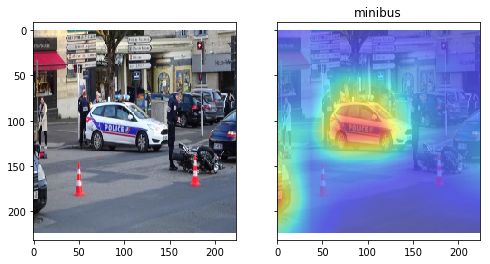

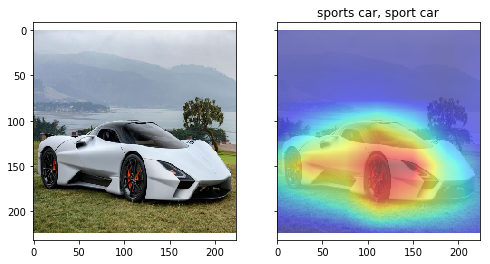

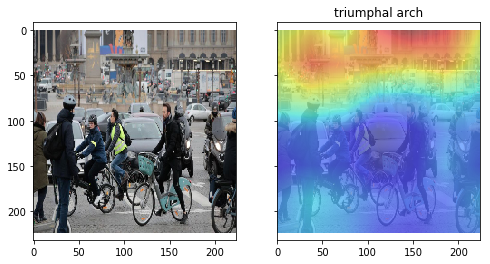

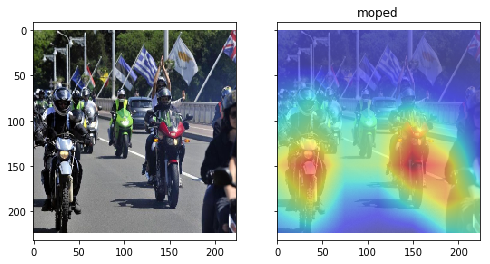

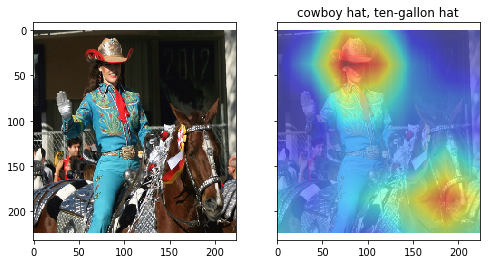

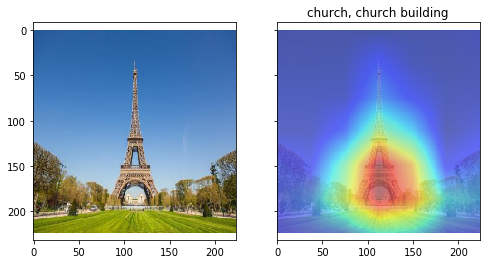

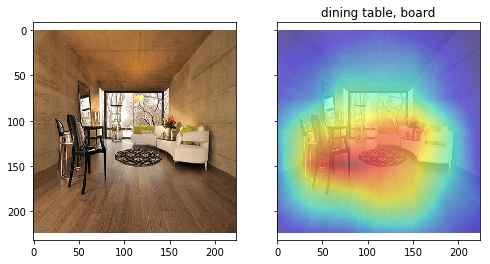

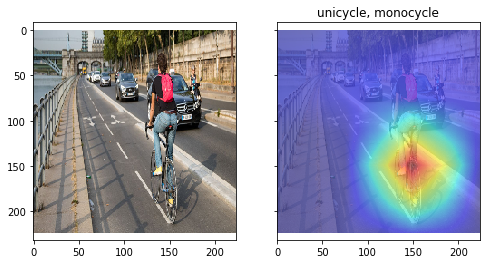

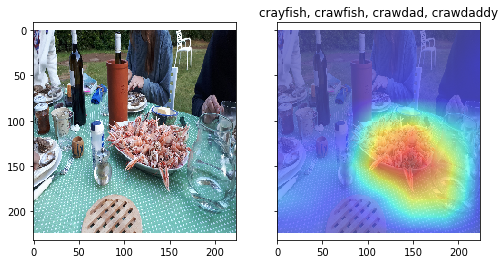

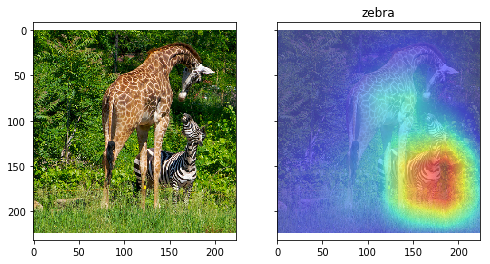

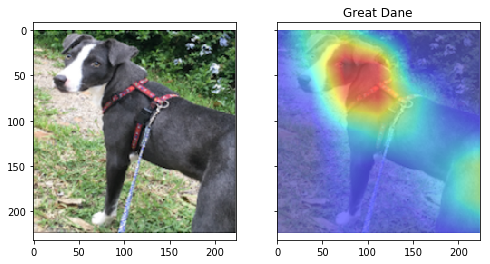

In [7]:
from glob import glob

if __name__ == '__main__':
    ResNet_model, all_amp_layer_weights = get_ResNet()
    my_files = np.array(glob("images/*"))
    for file in my_files: 
        #fig, ax = plt.subplots()
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=plt.figaspect(0.5))
        CAM = plot_ResNet_CAM(file, ax1, ax2, ResNet_model, all_amp_layer_weights)
        plt.show()